# Example 3: Pivot Uniformity Test

This notebook tests the uniformity of p-values (pivot) for both Pretrained Lasso and DTransFusion methods under the null hypothesis (no true signal, s=0).

In [1]:
import numpy as np
import sys
sys.path.append('..')

from ppl_si import PPL_SI_randj, DTF_SI_randj, generate_synthetic_data
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

## 1. Pretrained Lasso Pivot Test

In [2]:
def run_PPL(max_iter=1000):
    p = 300
    num_sh = 0      # No shared signal (null hypothesis)
    num_inv = 0     # No individual signal (null hypothesis)
    K = 5
    n_list = [100, 100, 100, 100, 50]
    true_beta_sh = 0
    Gamma = 0.1
    
    lambda_sh = 50
    lambda_K = 5
    rho = 0.5
    
    p_sel_list = []
    total_false_positives_detected = 0
    total_false_positives_rejected = 0
    
    alpha = 0.05
    
    for i in range(max_iter):
        if (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}/{max_iter}")
        
        X_list, Y_list, true_betaK, Sigma_list = generate_synthetic_data(
            p=p,
            num_sh=num_sh,
            num_inv=num_inv,
            K=K,
            n_list=n_list,
            true_beta_sh=true_beta_sh,
            Gamma=Gamma
        )
        p_sel = PPL_SI_randj(
            X_list=X_list,
            Y_list=Y_list,
            lambda_sh=lambda_sh,
            lambda_K=lambda_K,
            rho=rho,
            Sigma_list=Sigma_list,
            z_min=-20,
            z_max=20
        )
        
        if p_sel is not None:
            total_false_positives_detected += 1
            if p_sel <= alpha:
                total_false_positives_rejected += 1
            p_sel_list.append(p_sel)
    
    if total_false_positives_detected > 0:
        FPR = total_false_positives_rejected / total_false_positives_detected
    else:
        FPR = 0
    
    print(f'\nPretrained Lasso Results:')
    print(f'FPR = {FPR:.4f}')
    print(f'Total p-values collected: {len(p_sel_list)}')
    
    stat, p_val = stats.kstest(p_sel_list, 'uniform')
    print(f"KS-Test p-value: {p_val:.4f}")
    
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(10, 8))
    grid = np.linspace(0, 1, 101)
    plt.plot(grid, sm.distributions.ECDF(np.array(p_sel_list))(grid), 'r-', linewidth=6, label='PPL p-value')
    plt.plot([0, 1], [0, 1], 'k--', label='Uniform')
    plt.xlabel('x')
    plt.ylabel('ECDF')
    plt.title('Pretrained Lasso - Pivot Uniformity')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return p_sel_list

Iteration 100/300
Iteration 200/300
Iteration 300/300

Pretrained Lasso Results:
FPR = 0.0633
Total p-values collected: 300
KS-Test p-value: 0.8401


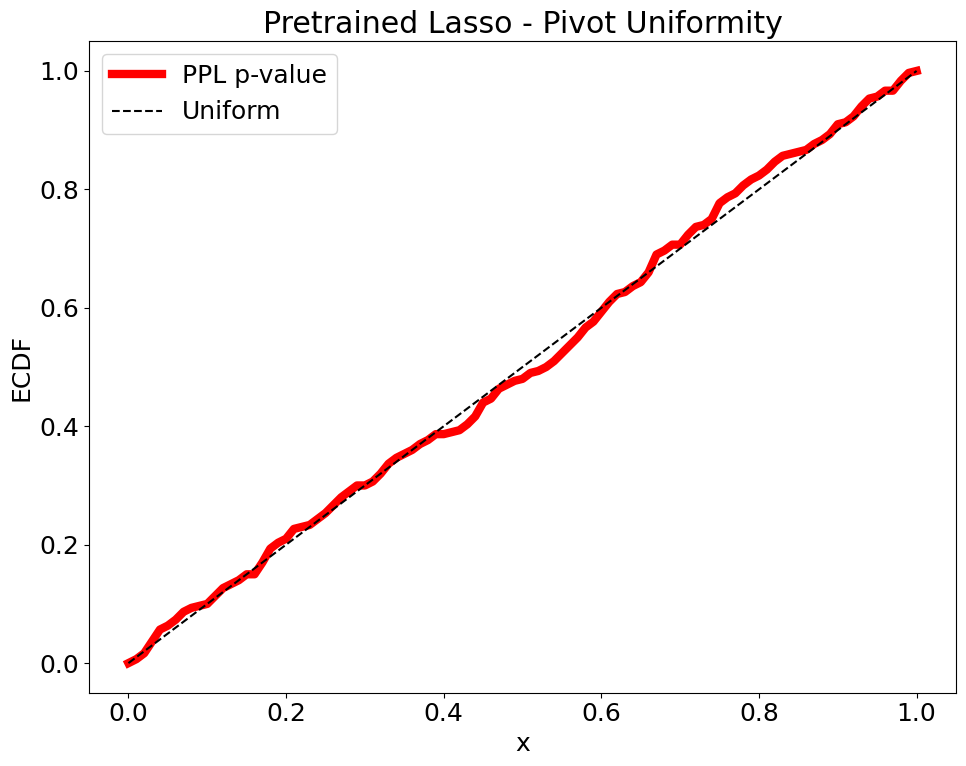

In [3]:
ppl_pvalues = run_PPL(max_iter=300)

## 2. DTransFusion Pivot Test

In [4]:
def run_DTF(max_iter=1000):
    p = 300
    num_sh = 0
    num_inv = 0
    K = 5
    n_list = [100, 100, 100, 100, 50]
    true_beta_sh = 0
    Gamma = 0.1
    
    lambda_k_list = [np.sqrt(1.0 * np.log(p) / n_list[k]) for k in range(K)]
    lambda_0 = 0.5 * np.sqrt(np.log(p) / sum(n_list))
    lambda_tilde = 1.0 * np.sqrt(np.log(p) / n_list[-1])
    qk_weights = [0.1 * np.sqrt(n_list[k] / sum(n_list)) for k in range(K - 1)]
    
    p_sel_list = []
    total_false_positives_detected = 0
    total_false_positives_rejected = 0
    
    alpha = 0.05
    
    for i in range(max_iter):
        if (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}/{max_iter}")
        
        X_list, Y_list, true_betaK, Sigma_list = generate_synthetic_data(
            p=p,
            num_sh=num_sh,
            num_inv=num_inv,
            K=K,
            n_list=n_list,
            true_beta_sh=true_beta_sh,
            Gamma=Gamma
        )
        
        p_sel = DTF_SI_randj(
            X_list=X_list,
            Y_list=Y_list,
            lambda_k_list=lambda_k_list,
            lambda_0=lambda_0,
            lambda_tilde=lambda_tilde,
            qk_weights=qk_weights,
            Sigma_list=Sigma_list,
            z_min=-20,
            z_max=20
        )
        
        if p_sel is not None:
            total_false_positives_detected += 1
            if p_sel <= alpha:
                total_false_positives_rejected += 1
            p_sel_list.append(p_sel)
    
    if total_false_positives_detected > 0:
        FPR = total_false_positives_rejected / total_false_positives_detected
    else:
        FPR = 0
    
    print(f'\nDTransFusion Results:')
    print(f'FPR = {FPR:.4f}')
    print(f'Total p-values collected: {len(p_sel_list)}')
    
    stat, p_val = stats.kstest(p_sel_list, 'uniform')
    print(f"KS-Test p-value: {p_val:.4f}")
    
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(10, 8))
    grid = np.linspace(0, 1, 101)
    plt.plot(grid, sm.distributions.ECDF(np.array(p_sel_list))(grid), 'b-', linewidth=6, label='DTF p-value')
    plt.plot([0, 1], [0, 1], 'k--', label='Uniform')
    plt.xlabel('x')
    plt.ylabel('ECDF')
    plt.title('DTransFusion - Pivot Uniformity')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return p_sel_list

In [ ]:
dtf_pvalues = run_DTF(max_iter=300)

### 3. Summary

This notebook demonstrates that under the null hypothesis (s=0, no true signal):

- The p-values from both **Pretrained Lasso** and **DTransFusion** should follow a uniform distribution
- The **FPR** (False Positive Rate) should be close to α = 0.05
- The **KS-test** p-value should be large (> 0.05), indicating no significant deviation from uniformity
- The **ECDF plot** should closely follow the diagonal line (uniform distribution)

These properties validate the correctness of the selective inference procedure.